In [3]:

# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

import rootutils
root = rootutils.setup_root("./scripts/", dotenv=True, pythonpath=True,  indicator =  [".project-root"], cwd = True)




from scripts.nb_functions import find_filtered_voronoi_neighbor_knn_limited_mask

from scripts.models import CustomGNN
from scripts.environment import Environment

In [4]:
# positions = np.load('quarters/positions.npy')
# print(positions.shape)

# # load data

# data = []
# for i in range(4):
#     for subpart in ["both", "BMP", "FGF"]:
#         dat = np.load(f"quarters/quarter_{i}_{subpart}_SMAD_and_ERK.npy")
#         dat = dat.swapaxes(1, 2)
#         data.append(dat)


# data = np.array(data)

positions = []

data = []

for i in range(4):
    positions.append(np.load(f"positions/random_{i}_positions.npy"))
    SMAD_ERK = np.load(f"positions/random_{i}_SMAD_and_ERK.npy")
    SMAD_ERK = SMAD_ERK.swapaxes(1, 2)

    SMAD_ERK[:,:,0] *= 100.
    print(SMAD_ERK.shape)
    data.append(SMAD_ERK)

(1001, 1000, 2)
(1001, 1000, 2)
(1001, 1000, 2)
(1001, 1000, 2)


TODO:

Get data from the actual system of interest

PINN!

Encoding?


IDEA:

Get latent space representation. Learn taylor paramaters.


Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [ ]:

model = CustomGNN(3, [4,4], 2)

env = Environment(data, positions)

env.set_model(model)

env.train(5000)


(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 10) (1000, 10)
5
0.001 loss: 0.41184625029563904
0.13608436286449432
10
0.002 loss: 0.39990106225013733
0.14107030630111694
15
0.003 loss: 0.3753369152545929
0.15099316835403442
20
0.004 loss: 0.36563292145729065
0.16413147747516632
25
0.005 loss: 0.3586720824241638
0.18030500411987305
30
0.006 loss: 0.35381120443344116
0.19979813694953918
35
0.007 loss: 0.34746915102005005
0.23221850395202637
40
0.008 loss: 0.33830609917640686
0.2846800982952118
45
0.009 loss: 0.3270258605480194
0.328554630279541
50
0.01 loss: 0.3144497275352478
0.3571816086769104
55
0.011 loss: 0.30941760540008545
0.380121111869812
60
0.012 loss: 0.30670347809791565
0.4018591046333313
65
0.013 loss: 0.30431729555130005
0.4199637472629547
70
0.014 loss: 0.3024411201477051
0.4333434998989105
75
0.015 loss: 0.30085670948028564
0.4426378011703491
80
0.016 loss: 0.29941290616989136
0.45025575160980225
85
0.017 loss: 0.2979954779148102
0.45652735233306885
9

In [ ]:
# save the model


torch.save(model.state_dict(), "model_poly_softplus.pt")


C:\Users\jakob\AppData\Local\Temp\ipykernel_17660\773046548.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(y_val[iii], dtype=torch.float32)
C:\Users\jakob\AppData\Local\Temp\ipykernel_17660\773046548.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y_val[iii+10] , dtype=torch.float32)


(1000, 9) (1000, 9)
pos (1000, 2) torch.Size([1000, 2])


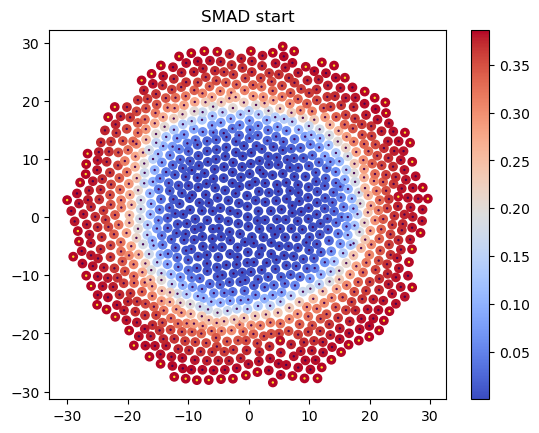

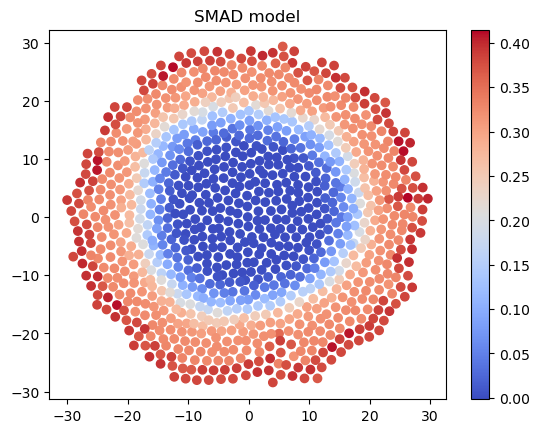

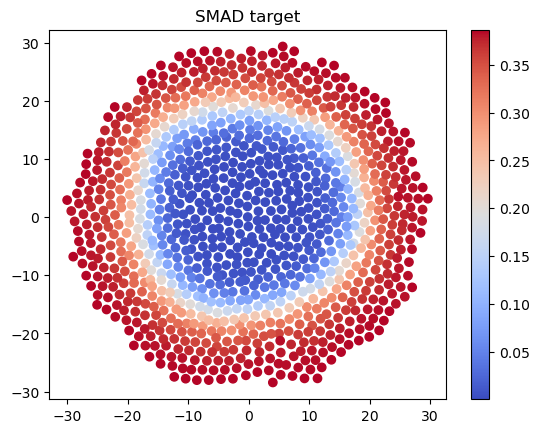

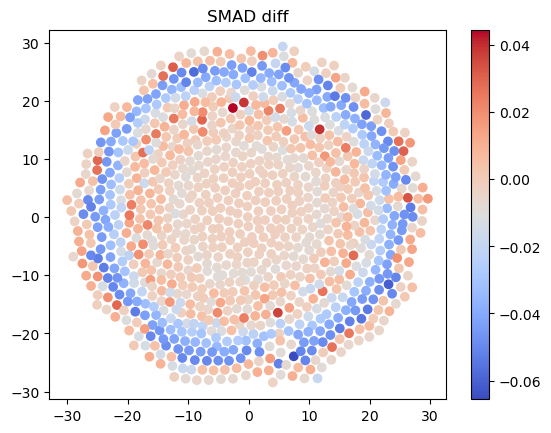

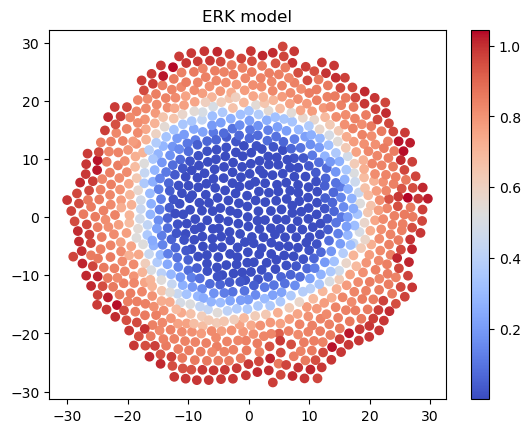

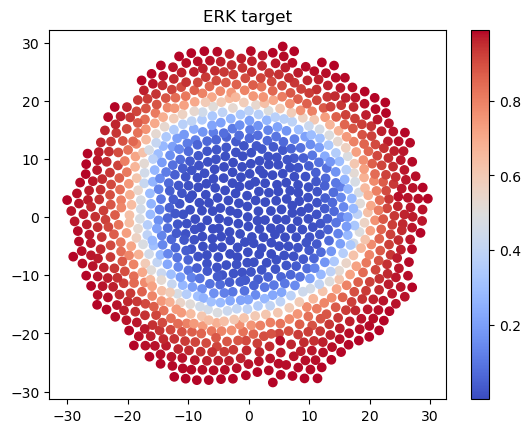

In [92]:
model.train(False)

# y_val = np.array([np.load(f'data/quarter_3_both.csv_BMP_levels.npy'), np.load(f'data/quarter_3_both.csv_FGF_levels.npy')])
y_val = env.ys[0]

poss = env.positions[0]

iii  = 600
X = torch.tensor(y_val[iii], dtype=torch.float32)
target = torch.tensor(y_val[iii+10] , dtype=torch.float32)

edges, edge_weights, border = env.get_edges(poss)

print("pos",poss.shape, X.shape)

# X = torch.cat((X, border.unsqueeze(1)), dim = 1)

out = env.call_model(X, edges, edge_weights, border)

out = out.detach().numpy()


plt.scatter(poss[:,0], poss[:,1], c=X[:,0], cmap='coolwarm')
plt.colorbar()
plt.scatter(poss[:,0], poss[:,1], c= env.border_mask[0], s= 0.5)
plt.title('SMAD start')
plt.show()

plt.scatter(poss[:,0], poss[:,1], c=out[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD model')
plt.show()


plt.scatter(poss[:,0], poss[:,1], c=target[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD target')
plt.show()

# plot diff

plt.scatter(poss[:,0], poss[:,1], c=(out[:,0] - target[:,0].detach().numpy()), cmap='coolwarm')
plt.colorbar()
plt.title('SMAD diff')
plt.show()



plt.scatter(poss[:,0], poss[:,1], c=out[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('ERK model')
plt.show()


plt.scatter(poss[:,0], poss[:,1], c=target[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('ERK target')
plt.show()



(1000, 9) (1000, 9)


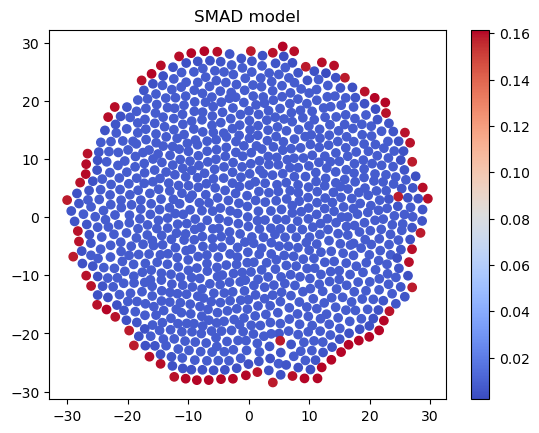

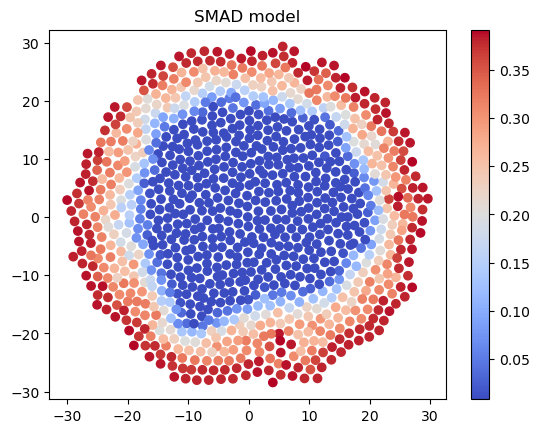

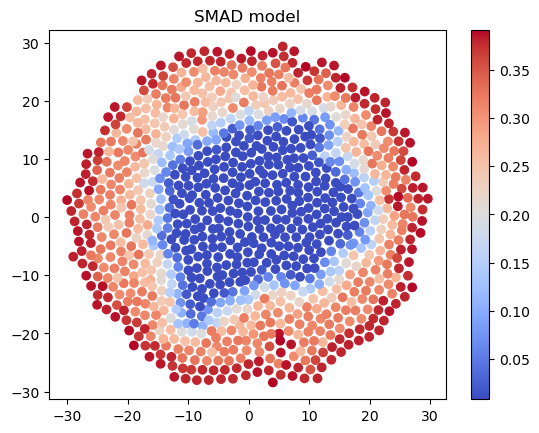

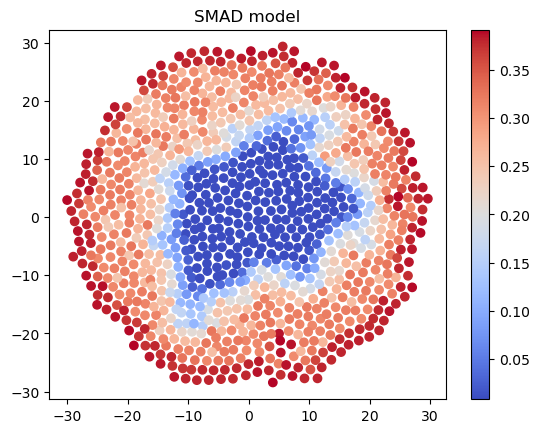

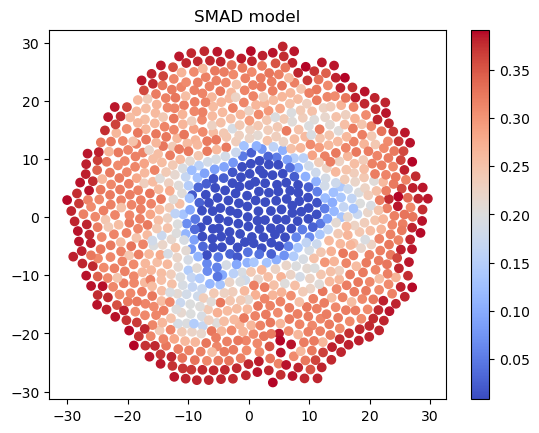

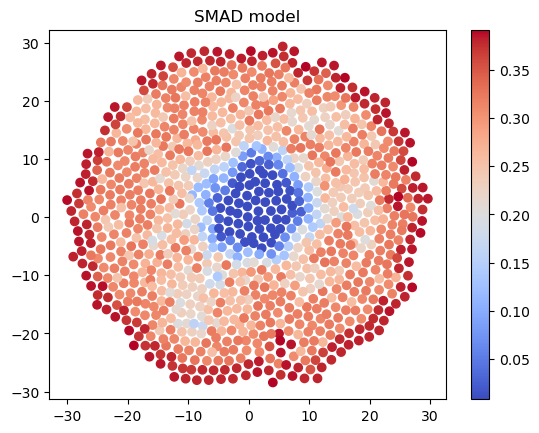

In [97]:
poss = env.positions[0]


edges, edge_weights, border = env.get_edges(poss)
X = torch.zeros_like(y_val[0], dtype=torch.float32)
for i in range(120*2):
    out = env.call_model(X, edges, edge_weights, border)

    out = out.detach().numpy()

    if i % 40 == 0:
        plt.scatter(poss[:,0], poss[:,1], c=out[:,0], cmap='coolwarm')
        plt.colorbar()
        plt.title('SMAD model')
        plt.show()

    X = torch.tensor(out, dtype=torch.float32)

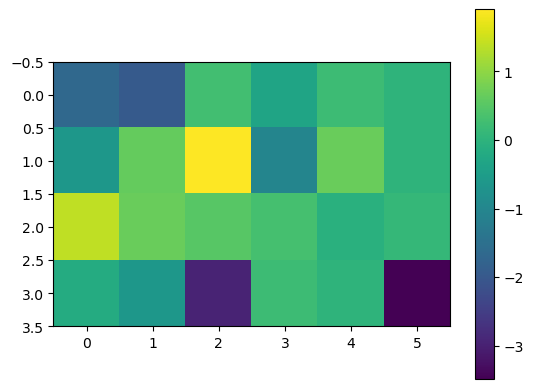

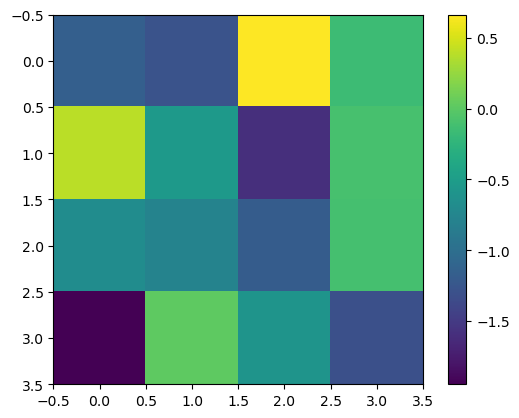

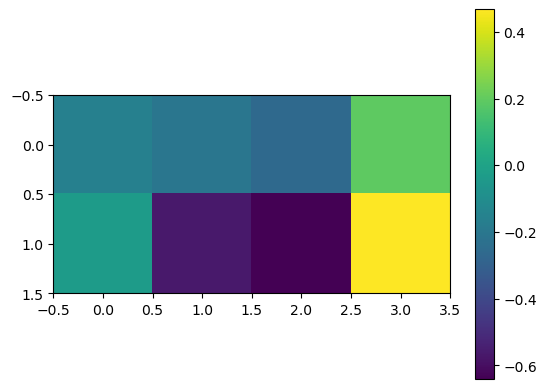

In [98]:
weights = [w.detach().numpy() for w in model.get_weights()]

for w in weights:
    plt.imshow(w)
    plt.colorbar()
    plt.show()

[6, 4, 4, 2]


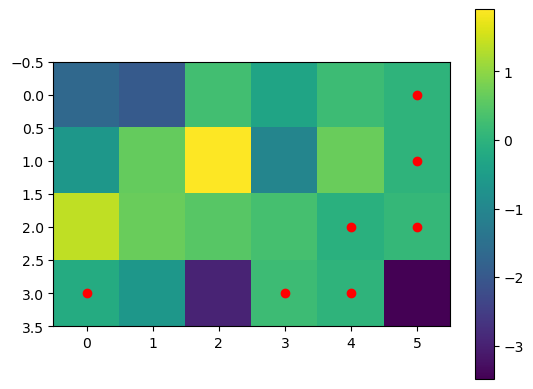

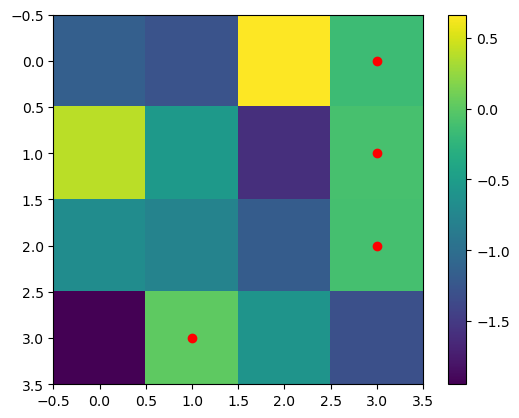

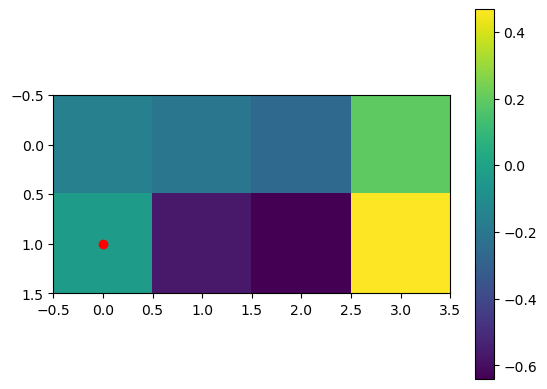

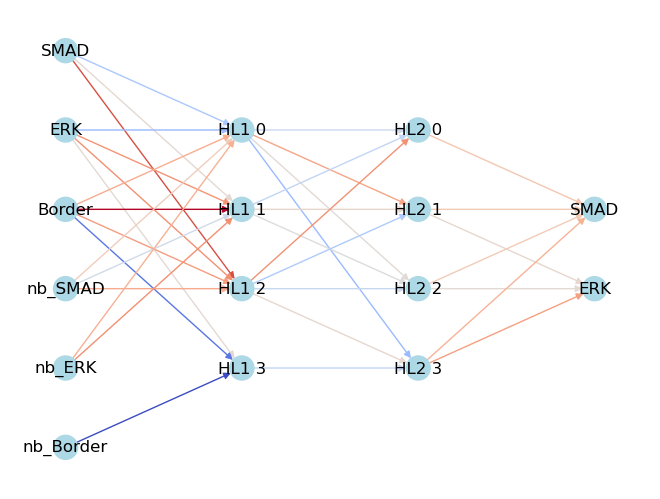

In [100]:
import networkx as nx

weights = [w.detach().numpy() for w in model.get_weights()]


sizes = [w.shape[0] for w in weights]
sizes = [weights[0].shape[1]] + sizes

print(sizes)

G = nx.complete_multipartite_graph(*sizes)
pos = nx.multipartite_layout(G)

DG = G.to_directed()

# remove all edges
DG.remove_edges_from(list(DG.edges()))

# find nodes in each layer
nodes_in_subsets = [[] for _ in range(len(sizes))]
for node in DG.nodes(data=True):
    subset = node[1]['subset']
    nodes_in_subsets[subset].append(node[0])

prune_masks = []
# remove edges with small weights
for weight_matrix_i in range(len(weights)):
    weight_matrix = weights[weight_matrix_i]

    weight_matrix_iii = weight_matrix_i #+ (-1 if weight_matrix_i != 0 else 0) # beacause first two are for same layer

    edges_to_add = []
    mean_mag = np.mean(np.abs(weight_matrix))

    to_remove_mask = np.ones_like(weight_matrix, dtype=bool)
    for i, w in enumerate(weight_matrix):
        mean_mag_row = np.mean(np.abs(w))
        for j, w_ in enumerate(w):
            sens = 0.2
            if np.abs(w_) > sens*mean_mag and np.abs(w_) > sens*mean_mag_row:
                edges_to_add.append((nodes_in_subsets[weight_matrix_iii][j], nodes_in_subsets[weight_matrix_iii+1][i], {"weight":w_}))
                to_remove_mask[i, j] = False

    DG.add_edges_from(edges_to_add)

    prune_masks.append(to_remove_mask)
    plt.imshow(weight_matrix)
    plt.colorbar()
    plt.scatter(np.where(to_remove_mask)[1], np.where(to_remove_mask)[0], c='r')
    plt.show()


# # remove nodes with no outgoing edges or incoming edges
node_colors = []
for node in DG.nodes(data=True):
    col = "lightblue"
    if len(list(DG.in_edges(node[0]))) == 0 and not node[1]['subset'] == 0:
        col = 'r'
    elif len(list(DG.out_edges(node[0]))) == 0 and not node[1]['subset'] == len(sizes)-1:
        col = 'r'

    node_colors.append(col)

# color the edges based on the weight matrix


labels = {}

for node in nodes_in_subsets[0]:
    n = node - nodes_in_subsets[0][0]
    names  = ["SMAD", "ERK", "Border", "nb_SMAD", "nb_ERK", "nb_Border"]
    labels[node] = names[n]

for node in nodes_in_subsets[-1]:
    n = node - nodes_in_subsets[-1][0]
    names = ["SMAD", "ERK"]
    labels[node] = names[n]

for i in range(1, len(sizes)-1):
    for node in nodes_in_subsets[i]:
        n = node - nodes_in_subsets[i][0]
        labels[node] = f"HL{i} {n}"
        

        

cmap = plt.cm.coolwarm
nx.draw(DG, pos, with_labels=True, node_color=node_colors, edge_color=[DG[u][v]['weight'] for u,v in DG.edges()], edge_cmap=cmap, labels=labels)
plt.show()



In [73]:
import sympy as sp

# set up the variables
S = sp.symbols('S', positive=True, real=True)
E = sp.symbols('E', positive=True, real=True)
B = sp.symbols('B', positive=True, real=True)
nb_S = sp.symbols('S_nb', positive=True, real=True)
nb_E = sp.symbols('E_nb', positive=True, real=True)
nb_B = sp.symbols('B_nb', positive=True, real=True)

inp_vec = sp.Matrix([nb_S, nb_E, nb_B, S, E, B])

# calculate the first layer
W0 = sp.Matrix(weights[0] * ~prune_masks[0])

X = W0*inp_vec
# activation = sp.Function('\sigma')

# squared
# activation = lambda x: x**2

# sigmoid
# activation = lambda x: 1/(1 + sp.exp(-x))

# softplus
activation = lambda x: sp.log(1 + sp.exp(x))


for i in range(1, len(weights)):
    W = sp.Matrix(weights[i] * ~prune_masks[i])
    X = W*X

    if i != len(weights)-1:
        X = sp.Matrix([activation(x) for x in X])

# define the activation function



# calculate the second layer

# simplify the expression


X

Matrix([
[                                                                                              -0.408634*log(exp(-0.0395572*B + 0.0269089*B_nb - 0.302306*E_nb + 0.039248*S - 0.110666*S_nb) + 1) - 0.237217*log(exp(-0.036475*B - 1.34522*B_nb - 1.03149*E_nb - 0.172831*S - 1.2408*S_nb) + 1) + 0.258828*log(exp(1.25091*B + 1.03831*B_nb + 0.842154*E_nb - 0.0356051*S + 0.673494*S_nb) + 1)],
[0.487652*log(exp(-0.0395572*B + 0.0269089*B_nb - 0.302306*E_nb + 0.039248*S - 0.110666*S_nb) + 1) - 0.643858*log(exp(-0.036475*B - 1.34522*B_nb - 1.03149*E_nb - 0.172831*S - 1.2408*S_nb) + 1) + 0.249247*log(exp(0.0140334*B - 0.165592*B_nb + 0.722589*E_nb - 0.12006*S + 0.28254*S_nb) + 1) + 0.62939*log(exp(1.25091*B + 1.03831*B_nb + 0.842154*E_nb - 0.0356051*S + 0.673494*S_nb) + 1)]])

In [78]:
# define differences 
S_diff = sp.symbols('S_diff', positive=True, real=True)
E_diff = sp.symbols('E_diff', positive=True, real=True)
B_diff = sp.symbols('B_diff', positive=True, real=True)

X_subbed = X.subs({S: nb_S + S_diff, E: nb_E + E_diff, B: nb_B + B_diff})

simp = sp.simplify(X_subbed,)
simp[1]


0.00419453*B_diff + 0.883447*B_nb + 0.516716*E_nb + 0.130418*S_diff + 0.875352*S_nb + 0.249247*log(exp(0.0140334*B_diff - 0.151559*B_nb + 0.722589*E_nb - 0.12006*S_diff + 0.16248*S_nb) + 1) - 0.643858*log(exp(0.036475*B_diff + 1.3817*B_nb + 1.03149*E_nb + 0.172831*S_diff + 1.41363*S_nb) + 1) + 0.487652*log(exp(0.0395572*B_diff + 0.0126483*B_nb + 0.302306*E_nb - 0.039248*S_diff + 0.0714184*S_nb) + 1) + 0.62939*log(exp(1.25091*B_diff + 2.28922*B_nb + 0.842154*E_nb - 0.0356051*S_diff + 0.637889*S_nb) + 1)

In [37]:
# create a function for the model
func = sp.lambdify([nb_S, nb_E, nb_B, S, E, B], simp[0], 'numpy')

In [47]:
np.log(np.exp(2+0.6+2) + 1)

np.float64(4.610001652055652)

In [ ]:
func

<function _lambdifygenerated(S_nb, E_nb, B_nb, S, E, B)>